<a href="https://colab.research.google.com/github/javicevallos/Backend/blob/master/HandsOn_M7_T3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hands-On: Machine Learning con Apache Spark ML**

## Objetivos

* Importar las bibliotecas de estadísticas y Spark ML
* Realizar operaciones estadísticas básicas con Spark
* Crear un modelo de regresión lineal simple con Spark ML
* Entrenar el modelo y realizar la evaluación.


##  Configuración

In [1]:
# Instalando los paquetes requeridos
!pip install pyspark
!pip install findspark

     |████████████████████████████████| 281.4 MB 26 kB/s 
     |████████████████████████████████| 198 kB 46.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=353b2c60ff4ce4fe0d2d5f73373df017b663b4b2275ddda5ca7d3c2209938c6d
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
# Pandas es un paquete popular de Python para Data Science. Usaremos Pandas para interactuar con archivos CSV
import pandas as pd
import matplotlib.pyplot as plt
# PySpark es la libreria que usa llamadas API para Python. PySpark se usa para inicializar el contexto de Spark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

## Actividad 1: Sesión de Spark y librerías de ML

En este ejercicio, creará e inicializará la sesión de Spark necesaria para cargar los marcos de datos y operar en ellos.

In [3]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
# Verificando la información de la sesión
spark

Ahora importará 4 funciones de 4 librerías de SparkML

1.   VectorAssembler(): esta función se utiliza para crear vectores de funciones a partir de dataframes/datos sin procesar. Estos vectores de características son necesarios para entrenar un modelo ML o realizar cualquier operación estadística.

2. Correlación (): esta función es de la biblioteca de estadísticas dentro de SparkML. Esta función se utiliza para calcular la correlación entre vectores de características.

3.   Normalized(): Esta función se utiliza para normalizar características. La normalización de las funciones conduce a una mejor convergencia del modelo de ML y resultados de entrenamiento.

4.  LinearRegression(): esta función se utiliza para crear un modelo de regresión lineal y entrenarlo. 

In [5]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression

## Actividad 2: Cargando Datos y creando vectores de características

Pandas es una biblioteca utilizada para la manipulación y el análisis de datos. Pandas ofrece estructuras de datos y operaciones para crear y manipular objetos Data Series y DataFrame. Los datos se pueden importar desde varias fuentes de datos, por ejemplo, matrices Numpy, diccionarios de Python y archivos CSV. Pandas le permite manipular, organizar y mostrar los datos.

En este ejemplo, usamos un conjunto de datos que contiene información sobre automóviles.


In [7]:
#Usamos ahorla función `createDataFrame` para cargar los datos en un dataframe de Spark
sdf = spark.createDataFrame(cars2)

In [31]:
#Descargamos el archivo cars2.csv que contiene datos de características de autos: mpg (millas por galón), hp (potencia - caballos de fuerza), y weight (peso)
cars2 = pd.read_csv('https://dl.dropboxusercontent.com/s/disr9eav3l9y13w/cars2.csv?dl=0 ', header=None, names=["mpg", "hp", "weight"])
cars2.head()


,mpg,hp,weight
0,18.0,130.0,3504.0
1,15.0,165.0,3693.0
2,18.0,150.0,3436.0
3,16.0,150.0,3433.0
4,17.0,140.0,3449.0


In [8]:
# Imprimiendo el esquema
sdf.printSchema()

root
 |-- mpg: double (nullable = true)
 |-- hp: double (nullable = true)
 |-- weight: double (nullable = true)



En esta parte, usamos la función VectorAssembler() para convertir las columnas del dataframe de Spark en vectores de características. Para nuestro ejemplo, usamos la potencia ("hp") y el peso del automóvil como características de entrada y las millas por galón ("mpg") como etiquetas objetivo.

In [9]:
assembler = VectorAssembler(
    inputCols=["hp", "weight"],
    outputCol="features")

output = assembler.transform(sdf).select('features','mpg')

Ahora dividiremos el set de datos en un conjunto para entramiento (traning) y otro para pruebas (testing)

In [10]:
train, test = output.randomSplit([0.75, 0.25])

## Actividad 3: Estadísticas básicas e ingeniería de características

En esta actividad, determinamos la correlación entre vectores de características y normalizamos las características.

### Correlación
Spark ML tiene una función de correlación incorporada como parte de la biblioteca Stat. Usamos la función de correlación para determinar los diferentes tipos de correlación entre las 2 características: "hp" y "peso".

In [11]:
r1 = Correlation.corr(train, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Pearson correlation matrix:
DenseMatrix([[1.        , 0.85670103],
             [0.85670103, 1.        ]])


In [12]:
r2 = Correlation.corr(train, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Spearman correlation matrix:
DenseMatrix([[1.        , 0.87529373],
             [0.87529373, 1.        ]])


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Podemos ver que hay una correlación de 0.86 (o 86%) entre las características. Eso es lógico ya que un automóvil con mayor potencia probablemente tenga un motor más grande y, por lo tanto, pese más. También podemos visualizar los vectores de características para ver que realmente están correlacionados.

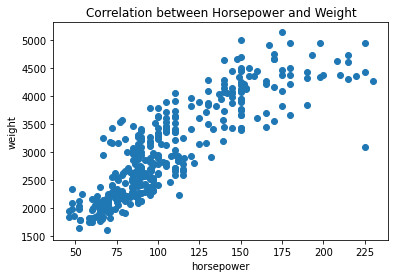

In [22]:
plt.figure()
plt.scatter(cars2["hp"], cars2["weight"])
plt.xlabel("horsepower")
plt.ylabel("weight")
plt.title("Correlation between Horsepower and Weight")
plt.show()

### Normalización
Para un mejor entrenamiento y convergencia del modelo, es una buena práctica normalizar los vectores de características.

In [14]:
normalizer = Normalizer(inputCol="features", outputCol="features_normalized", p=1.0)
train_norm = normalizer.transform(train)
print("Normalized using L^1 norm")
train_norm.show(5, truncate=False)

Normalized using L^1 norm
+-------------+----+-----------------------------------------+
|features     |mpg |features_normalized                      |
+-------------+----+-----------------------------------------+
|[46.0,1835.0]|26.0|[0.024455077086656035,0.9755449229133439]|
|[52.0,2035.0]|29.0|[0.024916147580258743,0.9750838524197413]|
|[60.0,2164.0]|24.5|[0.02697841726618705,0.9730215827338129] |
|[61.0,2003.0]|32.0|[0.029554263565891473,0.9704457364341085]|
|[65.0,1773.0]|31.0|[0.03536452665941241,0.9646354733405876] |
+-------------+----+-----------------------------------------+
only showing top 5 rows



Escalado estándar
Esta es una práctica estándar para escalar las características de modo que todas las columnas de las características tengan una media cero y una varianza unitaria.

In [15]:
standard_scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
train_model = standard_scaler.fit(train)
train_scaled = train_model.transform(train)
train_scaled.show(5, truncate=False)

+-------------+----+---------------------------------------+
|features     |mpg |features_scaled                        |
+-------------+----+---------------------------------------+
|[46.0,1835.0]|26.0|[1.213777801490797,2.151542079789483]  |
|[52.0,2035.0]|29.0|[1.3720966451635097,2.3860425789491]   |
|[60.0,2164.0]|24.5|[1.5831884367271265,2.5372954009070527]|
|[61.0,2003.0]|32.0|[1.6095749106725787,2.348522499083561] |
|[65.0,1773.0]|31.0|[1.715120806454387,2.078846925050002]  |
+-------------+----+---------------------------------------+
only showing top 5 rows



In [16]:
test_scaled = train_model.transform(test)
test_scaled.show(5, truncate=False)

+-------------+----+---------------------------------------+
|features     |mpg |features_scaled                        |
+-------------+----+---------------------------------------+
|[46.0,1950.0]|26.0|[1.213777801490797,2.286379866806263]  |
|[49.0,1867.0]|29.0|[1.2929372233271534,2.189062159655022] |
|[52.0,1649.0]|31.0|[1.3720966451635097,1.9334566155710398]|
|[53.0,1795.0]|33.0|[1.3984831191089617,2.10464197995756]  |
|[54.0,2254.0]|23.0|[1.424869593054414,2.64282062552888]   |
+-------------+----+---------------------------------------+
only showing top 5 rows



## Actividad 4: Construcción y entrenamiento de un modelo de regresión lineal
En este ejercicio, entrenamos un modelo de regresión lineal lrModel en nuestro conjunto de datos de entrenamiento. Entrenamos el modelo en la versión escalada estándar de características. También imprimimos las métricas finales de RMSE y R-Squared.

In [17]:
# Creando un modelo de regresión
lr = LinearRegression(featuresCol='features_scaled', labelCol='mpg', maxIter=100)

# Fitting
lrModel = lr.fit(train_scaled)

# Coeficientes e interceptos de la regresión lineal
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Sumarizando el modelo e imprimiendo algunas métricas
trainingSummary = lrModel.summary
#trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R-squared: %f" % trainingSummary.r2)

Coefficients: [-2.2368230006075667,-4.815103456715116]
Intercept: 46.70336860578772
RMSE: 4.394181
R-squared: 0.706492


###Pregunta 1: ¿Que son los coeficientes e interceptos de la regresión lineal?

### Pregunta 2: ¿Qué indican las métricas Root Mean Squared Error y R-Squared?

P1
El intercepto en un modelo de regresión representa el valor medio de la variable de respuesta cuando todas las variables predictoras del modelo son iguales a cero.

P2
RMSE es una forma útil de ver qué tan bien un modelo de regresión puede ajustarse a un conjunto de datos.
Cuanto mayor sea el RMSE, mayor será la diferencia entre los valores predichos y observados, lo que significa que peor se ajusta un modelo de regresión a los datos. Por el contrario, cuanto más pequeño sea el RMSE, mejor podrá un modelo ajustar los datos.

R2 es la mejor métrica. El valor alrededor de 0.4-0.5 es bueno. R-Squared es simplemente la fracción de la varianza de respuesta que es capturada por el modelo. Si R-Squared = 1, significa que el modelo se ajusta perfectamente a los datos. 


Como se observa que el  RMSE: 4.394181, es bajo podríamos deducir que el modelo se ajusta al conjunto de datos en estudio.

En el r cuadrado observamos que es alto con R-squared: 0.706492, nos ayuda a deducir que el modelo es bueno 
En muchos casos estas métricas se las deben evaluar gráficamente y con otros datos estadísticos para llegar a una conclusión idónea.



#### Predecir con nuevos datos

Una vez que se entrena un modelo, podemos `transform()` nuevos datos no vistos (por ejemplo, los datos de prueba) para generar predicciones.
En la celda a continuación, observe la columna de "predicción" que contiene el "mpg" previsto.

In [18]:
lrModel.transform(test_scaled).show(5)

+-------------+----+--------------------+------------------+
|     features| mpg|     features_scaled|        prediction|
+-------------+----+--------------------+------------------+
|[46.0,1950.0]|26.0|[1.21377780149079...| 32.97920690176354|
|[49.0,1867.0]|29.0|[1.29293722332715...| 33.27073611438871|
|[52.0,1649.0]|31.0|[1.37209664516350...| 34.32443763778468|
|[53.0,1795.0]|33.0|[1.39848311910896...|33.441140526161995|
|[54.0,2254.0]|23.0|[1.42486959305441...| 30.79073279771515|
+-------------+----+--------------------+------------------+
only showing top 5 rows



# Hands-on:  

 Imprima la matriz de correlación para la división del conjunto de datos de prueba que creamos anteriormente.

In [19]:
# Escriba su respuesta aquí



In [52]:
r11 = Correlation.corr(test, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.88599215],
             [0.88599215, 1.        ]])


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [46]:
r21 = Correlation.corr(test, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Spearman correlation matrix:
DenseMatrix([[1.        , 0.88717607],
             [0.88717607, 1.        ]])


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Normalice las funciones de entrenamiento utilizando la norma L2 del vector de funciones (ver sección de Normalización)

In [ ]:
# Escriba su respuesta aquí:

In [57]:
normalizer = Normalizer(inputCol="features", outputCol="features_normalized", p=1.0)
test_norm = normalizer.transform(test)
print("Normalized using L^2 norm")
test_norm.show(5, truncate=False)

Normalized using L^2 norm
+-------------+----+-----------------------------------------+
|features     |mpg |features_normalized                      |
+-------------+----+-----------------------------------------+
|[46.0,1950.0]|26.0|[0.023046092184368736,0.9769539078156313]|
|[49.0,1867.0]|29.0|[0.0255741127348643,0.9744258872651357]  |
|[52.0,1649.0]|31.0|[0.030570252792475015,0.969429747207525] |
|[53.0,1795.0]|33.0|[0.02867965367965368,0.9713203463203464] |
|[54.0,2254.0]|23.0|[0.02339688041594454,0.9766031195840554] |
+-------------+----+-----------------------------------------+
only showing top 5 rows



Repita el entrenamiento del modelo (Actividad 4) pero estra vez con el modelo obtenido en el punto anterior, por otras 100 iteraciones e informe los coeficientes.

In [ ]:
# Escriba su respuesta aquí

In [58]:
# Creando un modelo de regresión
lr1 = LinearRegression(featuresCol='features_scaled', labelCol='mpg', maxIter=100)

# Fitting
lrModel1 = lr1.fit(test_scaled)

# Coeficientes e interceptos de la regresión lineal
print("Coefficients: %s" % str(lrModel1.coefficients))
print("Intercept: %s" % str(lrModel1.intercept))

# Sumarizando el modelo e imprimiendo algunas métricas
trainingSummary = lrModel1.summary
#trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R-squared: %f" % trainingSummary.r2)

Coefficients: [-0.6400803911210226,-5.420252822329036]
Intercept: 43.407044177210075
RMSE: 3.517951
R-squared: 0.740134


In [59]:
lrModel1.transform(test_scaled).show(5)

+-------------+----+--------------------+------------------+
|     features| mpg|     features_scaled|        prediction|
+-------------+----+--------------------+------------------+
|[46.0,1950.0]|26.0|[1.21377780149079...|30.237371881324897|
|[49.0,1867.0]|29.0|[1.29293722332715...|30.714190064484075|
|[52.0,1649.0]|31.0|[1.37209664516350...|  32.0489683425183|
|[53.0,1795.0]|33.0|[1.39848311910896...| 31.10421092349753|
|[54.0,2254.0]|23.0|[1.42486959305441...|28.170257136359055|
+-------------+----+--------------------+------------------+
only showing top 5 rows



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Pregunta 3: ¿Hay cambios en los resultados de los coeficientes? ¿Qué modelo es mejor? Explique su respuesta

 Su respuesta: en el modelo primero teine estos coeficientesCoefficients: [-2.2368230006075667,-4.815103456715116]---,  en el de prueba tienen estos Coefficients: [-0.6400803911210226,-5.420252822329036], si hay cambios.

 En los modelos se evidencia métricas diferentes, pero en análisis el segundo modelo es mejor ya que el r cuadrado es más alto con 0.740134

# Entregables

 

1.   Resultados de la ejecución de las tareas en PDF
2.   Notebook en formato ipynb
3.   Si trabajó en grupo indicar el nombre de los integrantes y subir la tarea solo una vez.



###AUTORES: JAVIER CEVALLOS

*Referencias:*

*Introduction to Big Data with Spark and Hadoop, Coursera course by IBM* 